# Example 3. Feature Selection
---

There is several ways to deal with the overftting preoblem, e.g. adding regularization, reducing the model complexity or feature dimensions. Here we are going to introduce two ways to select the proper features for training: **Sequential backward selection** **(SBS)** and **Random forest**. Both method is to reducing the feature dimensions and keeps the significant ones. 

### Import class and data
Wine data is used for the exercises.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_wine = pd.read_csv('wine.data')
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanolds', 
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanolds,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
len(df_wine)

178

## 1. Sequential backward selection

The algorithm is a **greedy algorithm** which looks for best solution in each epochs. It scans all possible combination of the features. The number of feature dimentions is scaned from all to target number iteratively. Each epoch will choose a best combination with the highest test score and record it. The epoch will stop when it reachs the target number of feature dimension. The algorithm is described as following:
1. Look for the best combination of $k$ features in $t$ epoch: $\text{arg}\,\text{max}\,f(X_k),\ X_k(t)=\{X_k^{(1)},\ X_k^{(2)},..., X_k^{(d)}\},\ d=\frac{C_k^D}{k!},\ k=D-t$
2. Update the best (argmax) of $X_k(t)$ to $X_k(t+1)$, where $k=D-t-1$.
3. Stop if $k$ reaches $K$ or back to (1.) iteratively

Where $f$ is a certain training model; $X_k$ is the dataset with $k$ number of dimention, and it includes $d$ possible combinations; $D$ is the number of total features; $K$ is the target number of dimention, i.e. $D>k$; $t$ is the number of iteration. The detail code can be looked at [sbs.py](sbs.py). 

The following we simply show a small exercise about performance of the feature selection evolutionally with this algorithm:

In [4]:
from sbs import SBS

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

<sbs.SBS instance at 0x11978f290>

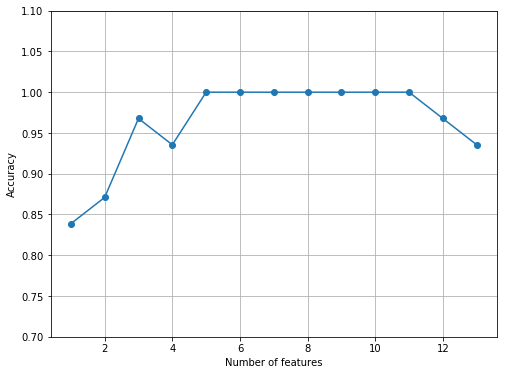

In [8]:
k_feat = [len(k) for k in sbs.subsets_]
plt.figure(figsize=(8, 6))
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Test Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

From above exercise we can see the proper features can give better perfomance. However, the less features may also has bad reaults, since it may lose the significant information for training.

In [12]:
# Before feature selection
knn.fit(X_train_std, y_train)
print 'Training accuracy:', knn.score(X_train_std, y_train)
print 'Test accuracy:', knn.score(X_test_std, y_test)

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [9]:
# After feature selection with 5 features
k5 = list(sbs.subsets_[8])
print df_wine.columns[1:][k5]

Index([u'Alcohol', u'Malic acid', u'Alcalinity of ash', u'Hue', u'Proline'], dtype='object')


In [13]:
knn.fit(X_train_std[:, k5], y_train)
print 'Training acuracy:', knn.score(X_train_std[:, k5], y_train)
print 'Test accuracy:', knn.score(X_test_std[:, k5], y_test) 

Training acuracy: 0.959677419355
Test accuracy: 0.962962962963


After using only 5 significant features for training, the test accuracy is improved and reduces the slight overfitting before selection.

## 2. Feature importance (Random forest)

We also can use the spectial feature of random forest to observe the feature importances. The random forest selects the most **gain information** of certain combination of features for getting a decision tree the training. Thus, we can use the averge of **impurity** of the decision trees to have features importances. We can simply call the function *feature*\_*importances*\_ in *sklearn* to find out the behavior.

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print "%2d) %-*s %f"%(f+1, 30, feat_labels[f], importances[indices[f]])

 1) Alcohol                        0.182483
 2) Malic acid                     0.158610
 3) Ash                            0.150948
 4) Alcalinity of ash              0.131987
 5) Magnesium                      0.106589
 6) Total phenols                  0.078243
 7) Flavanolds                     0.060718
 8) Nonflavanoid phenols           0.032033
 9) Proanthocyanins                0.025400
10) Color intensity                0.022351
11) Hue                            0.022078
12) OD280/OD315 of diluted wines   0.014645
13) Proline                        0.013916


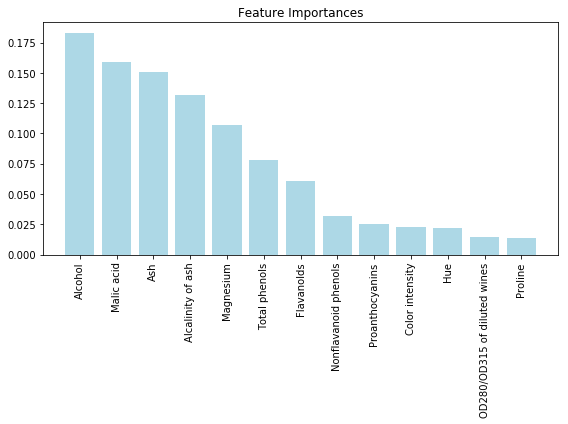

In [18]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

As we have done in SBS algorithm, the first 2 features, Achohol and Malic acid have stroger importances. Thus, it is an alternative way to select proper feature in preprocessing. 